In [1]:
import pandas as pd
import matplotlib.pyplot as plt

__Introduction & dataset overview__ :


ACCRE staff have hypothesized that the scheduler sometimes becomes unresponsive because it is processing large bursts of job completions. This especially affects automated job submitters, such as members of the Open Science Grid.

The goal is to evaluate whether the data supports the hypothesis of bursts of job completions contributing to scheduler unresponsiveness.

The Project makes use of three datasets:  

* fullsample.csv: Contains slurm job records. Job completions correspond to jobs in the "COMPLETED" state with exit code "0:0".  
* slurm_wrapper_ce5.log, slurm_wrapper_ce6.log: These log files contain every slurm command executed by the CE5 and CE6 servers (gateways to the Open Science Grid).  
Unresponsive periods are indicated by "sbatch" commands from user 9204 that have:  
    * return code = 1
    * execution time > 15 seconds

**Phase 1: Explore the Data**  
Objectives:  
* Understand the purpose of each dataset.  
* Inspect column types, sizes, and example rows.  

In [2]:
# Read the fullsample dataset into jobs dataframe
jobs = pd.read_csv("../data/fullsample.csv")
jobs.head()

,JOBID,STATE,BEGIN,END,REQMEM,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,PARTITION,EXITCODE
0,30616928,RUNNING,2021-07-31T22:15:00,Unknown,2048Mn,0,10:04:00,67-22:14:22,1,1,production,0:0
1,30853133,COMPLETED,2021-08-06T11:36:09,2021-09-05T11:36:32,262144Mn,20604.62M,30-00:00:00,30-00:00:23,1,1,cgw-platypus,0:0
2,30858137,COMPLETED,2021-08-06T19:04:39,2021-09-05T19:04:53,204800Mn,57553.77M,30-00:00:00,30-00:00:14,1,32,cgw-tbi01,0:0
3,30935078,COMPLETED,2021-08-09T16:52:51,2021-09-07T20:52:55,65536Mn,20577.96M,29-04:00:00,29-04:00:04,1,8,cgw-platypus,0:0
4,31364111_2,COMPLETED,2021-08-17T07:45:07,2021-09-10T16:45:24,16384Mn,9733.43M,24-09:00:00,24-09:00:17,1,1,production,0:0


In [3]:
jobs.shape

(7395885, 12)

* jobs dataframe contains 7395885 rows and 12 columns

* The fullsample dataset contains job records, with one row per job.

* Each job gets a unique ID, contained in the **JOBID** column.

* Some jobs can be submitted as arrays of similar jobs. These are listed with an underscore in the JOBID, where the number after the   underscore indicates the tasknumber. For example. JOBID 31781951 was an array job with 10 parts.

In [4]:
jobs.columns

Index(['JOBID', 'STATE', 'BEGIN', 'END', 'REQMEM', 'USEDMEM', 'REQTIME',
       'USEDTIME', 'NODES', 'CPUS', 'PARTITION', 'EXITCODE'],
      dtype='object')

column | description
-------|---------
JOBID | The identification number of the job or job step. Array jobs are in the form ArrayJobID_ArrayTaskID
STATE | Job state or status (COMPLETED, CANCELLED, FAILED, TIMEOUT, PREEMPTED, etc.)
BEGIN | Beginning time for the job.
END | Ending time for the job.
REQMEM | Requested memory in megabytes. May be per-core (Mc) or per-node (Mn)
USEDMEM | Used memory in megabytes per-node
REQTIME | Requested time in d-hh:mm:ss or hh:mm:ss
USEDTIME | Used time in d-hh:mm:ss or hh:mm:ss
NODES | Number of servers used for this job
CPUS | Total number of CPU-cores allocated to the job
PARTITION | Identifies the partition on which the job ran.
EXITCODE | The exit code returned by the job script or salloc, typically as set by the exit() function. Following the colon is the signal that caused the process to terminate if it was terminated by a signal.

In [5]:
jobs.info(show_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7395885 entries, 0 to 7395884
Data columns (total 12 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   JOBID      7395885 non-null  object
 1   STATE      7395885 non-null  object
 2   BEGIN      7395885 non-null  object
 3   END        7395885 non-null  object
 4   REQMEM     7395885 non-null  object
 5   USEDMEM    7395885 non-null  object
 6   REQTIME    7395885 non-null  object
 7   USEDTIME   7395885 non-null  object
 8   NODES      7395885 non-null  int64 
 9   CPUS       7395885 non-null  int64 
 10  PARTITION  7395885 non-null  object
 11  EXITCODE   7395885 non-null  object
dtypes: int64(2), object(10)
memory usage: 677.1+ MB


* All the columns in the jobs dataframe contain non null values

In [6]:
(jobs['JOBID'].value_counts()>1).sum()

np.int64(0)

* Each row contains each JOBID

In [7]:
jobs['NODES'].value_counts().sort_values(ascending =False).reset_index()

,NODES,count
0,1,7385963
1,2,3525
2,3,2716
3,8,1447
4,4,860
...,...,...
70,133,1
71,28,1
72,26,1
73,65,1


Most jobs ran on 1,2,3 and 8 nodes.

In [8]:
jobs['PARTITION'].value_counts().sort_values(ascending =False)

PARTITION
production              7019578
nogpfs                   147229
pascal                   124453
sam                       64967
turing                    21424
maxwell                   11278
cgw-maizie                 4309
debug                      1616
cgw-platypus                379
cgw-dsi-gw                  228
cgw-capra1                  157
cgw-dougherty1              125
cgw-horus                    61
cgw-cqs1                     28
cgw-hanuman                  21
cgw-sideshowbob              14
cgw-vm-qa-flatearth1          9
cgw-tbi01                     8
cgw-rocksteady                1
Name: count, dtype: int64

Most jobs ran on the "production","nogpfs" and "pascal" partitions.

In [9]:
jobs.groupby(['STATE','EXITCODE'])['JOBID'].count().sort_values(ascending =False)

STATE                EXITCODE
COMPLETED            0:0         7375084
CANCELLED            0:0            5378
FAILED               1:0            2780
CANCELLED            0:15           1886
OUT_OF_MEMORY        0:125          1739
                                  ...   
CANCELLED by 649311  0:0               1
CANCELLED by 649321  0:15              1
CANCELLED by 651701  0:9               1
CANCELLED by 879160  1:0               1
CANCELLED by 161909  0:0               1
Name: JOBID, Length: 227, dtype: int64

We can see that most of the jobs are in "COMPLETED" with EXITCODE "0:0" then followed by CANCELLED and FAILED.

In [10]:
jobs[jobs['STATE']=='RUNNING']['END'].unique()

array(['Unknown'], dtype=object)

As we can see, if the job is in 'RUNNING' state the 'END' will be always in 'unknown'(date time)

In [11]:
#convert the BEGIN and END columns to date time format
jobs['BEGIN'] = pd.to_datetime(jobs['BEGIN'],
                                           format = "%Y-%m-%dT%H:%M:%S", errors='coerce')

jobs['END'] = pd.to_datetime(jobs['END'],
                                           format = "%Y-%m-%dT%H:%M:%S", errors='coerce')



In [12]:
#convert the USEDTIME and REQTIME columns to timedelta format

jobs['USEDTIME'] = pd.to_timedelta(jobs['USEDTIME'].str.replace("-", " days ", 1))
jobs['REQTIME'] = pd.to_timedelta(jobs['REQTIME'].str.replace("-", " days ", 1))

In [13]:
 jobs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7395885 entries, 0 to 7395884
Data columns (total 12 columns):
 #   Column     Dtype          
---  ------     -----          
 0   JOBID      object         
 1   STATE      object         
 2   BEGIN      datetime64[ns] 
 3   END        datetime64[ns] 
 4   REQMEM     object         
 5   USEDMEM    object         
 6   REQTIME    timedelta64[ns]
 7   USEDTIME   timedelta64[ns]
 8   NODES      int64          
 9   CPUS       int64          
 10  PARTITION  object         
 11  EXITCODE   object         
dtypes: datetime64[ns](2), int64(2), object(6), timedelta64[ns](2)
memory usage: 677.1+ MB


In [14]:
jobs.sample(5)

,JOBID,STATE,BEGIN,END,REQMEM,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,PARTITION,EXITCODE
2011800,31142309_9118,COMPLETED,2021-08-12 14:03:57,2021-08-12 14:11:45,4096Mn,165.65M,0 days 08:00:00,0 days 00:07:48,1,1,production,0:0
225433,32120607_26,COMPLETED,2021-09-07 00:02:15,2021-09-07 11:09:27,6144Mc,2421.01M,1 days 00:00:00,0 days 11:07:12,1,1,production,0:0
3111505,29826748_343,COMPLETED,2021-06-22 14:55:42,2021-06-22 15:01:17,4096Mn,285.29M,0 days 08:00:00,0 days 00:05:35,1,1,production,0:0
3216770,29920688_961,COMPLETED,2021-06-26 12:05:35,2021-06-26 12:09:45,4096Mn,215.55M,0 days 08:00:00,0 days 00:04:10,1,1,production,0:0
5705510,26986425,COMPLETED,2021-01-27 16:19:41,2021-01-29 15:36:53,5000Mn,4189.90M,2 days 00:00:00,1 days 23:17:12,1,1,production,0:0


The __slurm_wrapper_ce5.log__ and __slurm_wrapper_ce6.log__ files contain logs of jobs submitted from the Open Science Grid.

In [15]:
# Read the slurm_wrapper_ce5.log dataset into jobs ce5

ce5 = pd.read_csv('../data/slurm_wrapper_ce5.log',
                  header=None,
                  delimiter=' - ',
                  engine='python')

ce5.head()

,0,1,2,3,4,5
0,2020-10-16 08:15:39.278699,user 0,retry 0,time 0.07347559928894043,returncode 0,"command ['/usr/bin/sacct', '-u', 'appelte1', '..."
1,2020-10-16 08:18:08.313309,user 0,retry 0,time 0.18363237380981445,returncode 0,"command ['/usr/bin/sacct', '-u', 'appelte1', '..."
2,2020-10-16 08:22:48.128689,user 0,retry 0,time 0.07547116279602051,returncode 0,"command ['/usr/bin/sacct', '-u', 'appelte1', '..."
3,2020-10-16 08:25:13.257408,user 0,retry 0,time 0.09484362602233887,returncode 0,"command ['/usr/bin/sacct', '-u', 'appelte1', '..."
4,2020-10-16 08:31:01.460723,user 0,retry 0,time 0.07498788833618164,returncode 0,"command ['/usr/bin/sacct', '-u', 'appelte1', '..."


In [16]:
ce5.shape

(4770893, 6)

* ce5 dataframe contains 4770893 rows and 6 columns

In [17]:
ce5.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4770893 entries, 0 to 4770892
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   0       4770893 non-null  object
 1   1       4770893 non-null  object
 2   2       4770893 non-null  object
 3   3       4770893 non-null  object
 4   4       4770893 non-null  object
 5   5       4770893 non-null  object
dtypes: object(6)
memory usage: 218.4+ MB


In [18]:
# Rename the column names of ce5 dataframe

new_column_names = ['date', 'user', 'retry' , 'time', 'return_code', 'command']
ce5.columns = new_column_names
ce5.head()

,date,user,retry,time,return_code,command
0,2020-10-16 08:15:39.278699,user 0,retry 0,time 0.07347559928894043,returncode 0,"command ['/usr/bin/sacct', '-u', 'appelte1', '..."
1,2020-10-16 08:18:08.313309,user 0,retry 0,time 0.18363237380981445,returncode 0,"command ['/usr/bin/sacct', '-u', 'appelte1', '..."
2,2020-10-16 08:22:48.128689,user 0,retry 0,time 0.07547116279602051,returncode 0,"command ['/usr/bin/sacct', '-u', 'appelte1', '..."
3,2020-10-16 08:25:13.257408,user 0,retry 0,time 0.09484362602233887,returncode 0,"command ['/usr/bin/sacct', '-u', 'appelte1', '..."
4,2020-10-16 08:31:01.460723,user 0,retry 0,time 0.07498788833618164,returncode 0,"command ['/usr/bin/sacct', '-u', 'appelte1', '..."


In [19]:
# Read the slurm_wrapper_ce6.log dataset into jobs ce6

ce6 = pd.read_csv('../data/slurm_wrapper_ce6.log',
                  header=None,
                  delimiter=' - ',
                  engine='python')

ce6.head()

,0,1,2,3,4,5
0,2020-10-16 10:37:44.163454,user 9202,retry 0,time 0.08495402336120605,returncode 0,"command ['/usr/bin/scontrol', 'show', 'job', '..."
1,2020-10-16 10:37:44.206654,user 9202,retry 0,time 0.08943057060241699,returncode 0,"command ['/usr/bin/scontrol', 'show', 'job', '..."
2,2020-10-16 10:37:44.218760,user 9202,retry 0,time 0.05928945541381836,returncode 0,"command ['/usr/bin/scontrol', 'show', 'job', '..."
3,2020-10-16 10:37:44.256403,user 9202,retry 0,time 0.038695573806762695,returncode 0,"command ['/usr/bin/scontrol', 'show', 'job', '..."
4,2020-10-16 10:37:44.611603,user 9202,retry 0,time 0.03343677520751953,returncode 0,"command ['/usr/bin/scontrol', 'show', 'job', '..."


In [20]:
ce6.shape

(4776520, 6)

ce6 dataframe contains 4776520 rows and 6 columns

In [21]:
ce6.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4776520 entries, 0 to 4776519
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   0       4776520 non-null  object
 1   1       4776520 non-null  object
 2   2       4776520 non-null  object
 3   3       4776520 non-null  object
 4   4       4776520 non-null  object
 5   5       4776520 non-null  object
dtypes: object(6)
memory usage: 218.7+ MB


In [22]:
#Rename the column names

new_column_names = ['date', 'user', 'retry' , 'time', 'return_code', 'command']
ce6.columns = new_column_names
ce6.head()

,date,user,retry,time,return_code,command
0,2020-10-16 10:37:44.163454,user 9202,retry 0,time 0.08495402336120605,returncode 0,"command ['/usr/bin/scontrol', 'show', 'job', '..."
1,2020-10-16 10:37:44.206654,user 9202,retry 0,time 0.08943057060241699,returncode 0,"command ['/usr/bin/scontrol', 'show', 'job', '..."
2,2020-10-16 10:37:44.218760,user 9202,retry 0,time 0.05928945541381836,returncode 0,"command ['/usr/bin/scontrol', 'show', 'job', '..."
3,2020-10-16 10:37:44.256403,user 9202,retry 0,time 0.038695573806762695,returncode 0,"command ['/usr/bin/scontrol', 'show', 'job', '..."
4,2020-10-16 10:37:44.611603,user 9202,retry 0,time 0.03343677520751953,returncode 0,"command ['/usr/bin/scontrol', 'show', 'job', '..."


**Phase 2: Clean and Transform the Data**  
Objectives:  
* Extract job completions from fullsample.csv.  
* Parse CE5 and CE6 logs to identify unresponsive events.  
* Create analysis-ready features (time windows, completion counts, unresponsiveness indicators).  
* Optionally include other features (currently running jobs or resource usage, time-of-day).  


In [23]:
#Extract job completions from fullsample.csv

completed_jobs = jobs[(jobs['STATE'] == 'COMPLETED') &  (jobs['EXITCODE'] == '0:0')]
print(f' There are {completed_jobs.shape[0]} COMPLETED jobs in the dataset')

 There are 7375084 COMPLETED jobs in the dataset


In [24]:
# Parse CE5 and CE6 logs to identify unresponsive events.

#concat two dfs to stack the rows vertically , when both the data frames have same columns

concat_logs = pd.concat([ce5,ce6], ignore_index = True)

concat_logs.shape

(9547413, 6)

In [25]:
concat_logs.info(show_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9547413 entries, 0 to 9547412
Data columns (total 6 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   date         9547413 non-null  object
 1   user         9547413 non-null  object
 2   retry        9547413 non-null  object
 3   time         9547413 non-null  object
 4   return_code  9547413 non-null  object
 5   command      9547413 non-null  object
dtypes: object(6)
memory usage: 437.0+ MB


In [26]:
#convert the date column datatype  to date time format and truncate the milliseconds

concat_logs['date'] = pd.to_datetime(concat_logs['date'],errors='coerce').dt.floor('s')


In [27]:
concat_logs['date'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 9547413 entries, 0 to 9547412
Series name: date
Non-Null Count    Dtype         
--------------    -----         
9547398 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 72.8 MB


In [28]:
concat_logs['time'] = concat_logs['time'].str.replace('time', "", regex = False).astype(float)


In [29]:
concat_logs.info(show_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9547413 entries, 0 to 9547412
Data columns (total 6 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   date         9547398 non-null  datetime64[ns]
 1   user         9547413 non-null  object        
 2   retry        9547413 non-null  object        
 3   time         9547413 non-null  float64       
 4   return_code  9547413 non-null  object        
 5   command      9547413 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(4)
memory usage: 437.0+ MB


In [30]:
pd.set_option('display.max_colwidth', None) #To display the full column(here looking for command column) values with out cut off

unresponsive_jobs = concat_logs[(concat_logs['user'] == 'user 9204') & (concat_logs['return_code'] == 'returncode 1') & (concat_logs['time'] > 15) & (concat_logs['command'].str.contains(r"'/usr/bin/(sbatch)'"))]

/var/folders/n1/v3s1h2t95hb_nmn96mg49sbm0000gn/T/ipykernel_82814/3370394948.py:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  unresponsive_jobs = concat_logs[(concat_logs['user'] == 'user 9204') & (concat_logs['return_code'] == 'returncode 1') & (concat_logs['time'] > 15) & (concat_logs['command'].str.contains(r"'/usr/bin/(sbatch)'"))]


In [31]:
unresponsive_jobs.head()

,date,user,retry,time,return_code,command
49958,2020-10-18 06:53:44,user 9204,retry 0,20.038464,returncode 1,"command ['/usr/bin/sbatch', '/tmp/condor_g_scratch.0x55c1dd302460.1559883/bl_B3aCvf']"
49972,2020-10-18 06:54:04,user 9204,retry 1,20.048906,returncode 1,"command ['/usr/bin/sbatch', '/tmp/condor_g_scratch.0x55c1dd302460.1559883/bl_B3aCvf']"
50467,2020-10-18 07:47:25,user 9204,retry 0,20.082628,returncode 1,"command ['/usr/bin/sbatch', '/tmp/condor_g_scratch.0x55c1d9e86b90.1559883/bl_fa5Tsv']"
50473,2020-10-18 07:47:45,user 9204,retry 1,20.045221,returncode 1,"command ['/usr/bin/sbatch', '/tmp/condor_g_scratch.0x55c1d9e86b90.1559883/bl_fa5Tsv']"
50582,2020-10-18 07:53:33,user 9204,retry 0,20.041486,returncode 1,"command ['/usr/bin/sbatch', '/tmp/condor_g_scratch.0x55c1dcd1d3c0.1559883/bl_x3mVd1']"


In [32]:
completed_jobs.head(2)

,JOBID,STATE,BEGIN,END,REQMEM,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,PARTITION,EXITCODE
1,30853133,COMPLETED,2021-08-06 11:36:09,2021-09-05 11:36:32,262144Mn,20604.62M,30 days,30 days 00:00:23,1,1,cgw-platypus,0:0
2,30858137,COMPLETED,2021-08-06 19:04:39,2021-09-05 19:04:53,204800Mn,57553.77M,30 days,30 days 00:00:14,1,32,cgw-tbi01,0:0


In [33]:
# Import unresponsive_jobs files to csv 
unresponsive_jobs.to_csv('unresponsive_jobs.csv')
unresponsive_jobs.head()

,date,user,retry,time,return_code,command
49958,2020-10-18 06:53:44,user 9204,retry 0,20.038464,returncode 1,"command ['/usr/bin/sbatch', '/tmp/condor_g_scratch.0x55c1dd302460.1559883/bl_B3aCvf']"
49972,2020-10-18 06:54:04,user 9204,retry 1,20.048906,returncode 1,"command ['/usr/bin/sbatch', '/tmp/condor_g_scratch.0x55c1dd302460.1559883/bl_B3aCvf']"
50467,2020-10-18 07:47:25,user 9204,retry 0,20.082628,returncode 1,"command ['/usr/bin/sbatch', '/tmp/condor_g_scratch.0x55c1d9e86b90.1559883/bl_fa5Tsv']"
50473,2020-10-18 07:47:45,user 9204,retry 1,20.045221,returncode 1,"command ['/usr/bin/sbatch', '/tmp/condor_g_scratch.0x55c1d9e86b90.1559883/bl_fa5Tsv']"
50582,2020-10-18 07:53:33,user 9204,retry 0,20.041486,returncode 1,"command ['/usr/bin/sbatch', '/tmp/condor_g_scratch.0x55c1dcd1d3c0.1559883/bl_x3mVd1']"


__Merging unresponsive jobs logs with completed jobs using merge_asof() and matched each unresponsive events near by job comletions__

In [34]:
unresponsive_jobs = unresponsive_jobs.sort_values(by ='date')
completed_jobs = completed_jobs.sort_values(by = 'END')
merge_unresp_jobs = pd.merge_asof(left = unresponsive_jobs,right = completed_jobs,left_on= 'date', right_on = 'END')
print(f' After merging unresponsive jobs with completed jobs got {merge_unresp_jobs.shape[0]} rows and {merge_unresp_jobs.shape[1]} columns')

 After merging unresponsive jobs with completed jobs got 3296 rows and 18 columns


In [35]:
merge_unresp_jobs.head()

,date,user,retry,time,return_code,command,JOBID,STATE,BEGIN,END,REQMEM,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,PARTITION,EXITCODE
0,2020-10-18 06:16:25,user 9204,retry 0,20.037672,returncode 1,"command ['/usr/bin/sbatch', '/tmp/condor_g_scratch.0x5572a7c77310.3390891/bl_23341e2dd5ae']",25041808,COMPLETED,2020-10-18 06:08:07,2020-10-18 06:13:19,4096Mc,871.60M,0 days 12:00:00,0 days 00:05:12,1,1,production,0:0
1,2020-10-18 06:38:44,user 9204,retry 0,20.038736,returncode 1,"command ['/usr/bin/sbatch', '/tmp/condor_g_scratch.0x5572a841eb00.3390891/bl_9f06196a57ac']",25032600_8,COMPLETED,2020-10-17 16:47:50,2020-10-18 06:38:03,4096Mn,335.27M,0 days 23:00:00,0 days 13:50:13,1,1,production,0:0
2,2020-10-18 06:53:44,user 9204,retry 0,20.038464,returncode 1,"command ['/usr/bin/sbatch', '/tmp/condor_g_scratch.0x55c1dd302460.1559883/bl_B3aCvf']",25041598,COMPLETED,2020-10-18 06:31:59,2020-10-18 06:53:24,21878Mn,1.63M,2 days 00:00:00,0 days 00:21:25,1,8,nogpfs,0:0
3,2020-10-18 06:54:04,user 9204,retry 1,20.048906,returncode 1,"command ['/usr/bin/sbatch', '/tmp/condor_g_scratch.0x55c1dd302460.1559883/bl_B3aCvf']",25041598,COMPLETED,2020-10-18 06:31:59,2020-10-18 06:53:24,21878Mn,1.63M,2 days 00:00:00,0 days 00:21:25,1,8,nogpfs,0:0
4,2020-10-18 07:47:25,user 9204,retry 0,20.082628,returncode 1,"command ['/usr/bin/sbatch', '/tmp/condor_g_scratch.0x55c1d9e86b90.1559883/bl_fa5Tsv']",25042059,COMPLETED,2020-10-18 07:25:37,2020-10-18 07:47:02,21875Mn,1.83M,2 days 00:00:00,0 days 00:21:25,1,8,nogpfs,0:0


In [36]:
merge_unresp_jobs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3296 entries, 0 to 3295
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype          
---  ------       --------------  -----          
 0   date         3296 non-null   datetime64[ns] 
 1   user         3296 non-null   object         
 2   retry        3296 non-null   object         
 3   time         3296 non-null   float64        
 4   return_code  3296 non-null   object         
 5   command      3296 non-null   object         
 6   JOBID        3296 non-null   object         
 7   STATE        3296 non-null   object         
 8   BEGIN        3296 non-null   datetime64[ns] 
 9   END          3296 non-null   datetime64[ns] 
 10  REQMEM       3296 non-null   object         
 11  USEDMEM      3296 non-null   object         
 12  REQTIME      3296 non-null   timedelta64[ns]
 13  USEDTIME     3296 non-null   timedelta64[ns]
 14  NODES        3296 non-null   int64          
 15  CPUS         3296 non-null   int64    

__TIME WINDOWS__

In [37]:
# calculated the time difference between date and end date to see how close job completions were to the unresponsive time

merge_unresp_jobs['diff_date_end'] = merge_unresp_jobs['date'] - merge_unresp_jobs['END']

In [38]:
merge_unresp_jobs.head(2)

,date,user,retry,time,return_code,command,JOBID,STATE,BEGIN,END,REQMEM,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,PARTITION,EXITCODE,diff_date_end
0,2020-10-18 06:16:25,user 9204,retry 0,20.037672,returncode 1,"command ['/usr/bin/sbatch', '/tmp/condor_g_scratch.0x5572a7c77310.3390891/bl_23341e2dd5ae']",25041808,COMPLETED,2020-10-18 06:08:07,2020-10-18 06:13:19,4096Mc,871.60M,0 days 12:00:00,0 days 00:05:12,1,1,production,0:0,0 days 00:03:06
1,2020-10-18 06:38:44,user 9204,retry 0,20.038736,returncode 1,"command ['/usr/bin/sbatch', '/tmp/condor_g_scratch.0x5572a841eb00.3390891/bl_9f06196a57ac']",25032600_8,COMPLETED,2020-10-17 16:47:50,2020-10-18 06:38:03,4096Mn,335.27M,0 days 23:00:00,0 days 13:50:13,1,1,production,0:0,0 days 00:00:41


* First sort the dataset by diff_date_end and use it as the index. Then group the records by this time field to calculate how many jobs were completed during each interval.

In [39]:
unresp_jobs_copy = merge_unresp_jobs.copy()
unresp_jobs_copy = unresp_jobs_copy.sort_values('diff_date_end').set_index('diff_date_end')

In [40]:
num_jobs = unresp_jobs_copy.groupby('diff_date_end').size().reset_index()
num_jobs.columns = ['diff_date_end', 'num_jobs_completed']

* calculate rolling windows for different time intervals and visualize

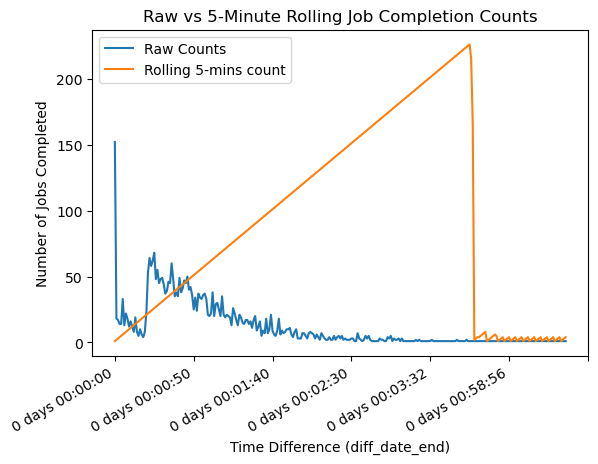

In [41]:
# Compute a 5-minute rolling count of completed jobs
num_jobs['rolling_5min'] = num_jobs.rolling(window ='5min', on='diff_date_end')['num_jobs_completed'].count()

# Visualization of the 5-min rolling count of completed jobs
ax = num_jobs.plot(x='diff_date_end', y='num_jobs_completed', label= 'Raw Counts')
num_jobs.plot(x='diff_date_end', y='rolling_5min', label= 'Rolling 5-mins count', ax=ax)
ax.set_xlabel("Time Difference (diff_date_end)")
ax.set_ylabel("Number of Jobs Completed")
ax.set_title("Raw vs 5-Minute Rolling Job Completion Counts")
ax.legend();

In [42]:
#checking the number of jobs completed after one hour
after_1hour = merge_unresp_jobs[merge_unresp_jobs['diff_date_end'] > '0 days 01:00:00'].shape[0]
print(f'number of unresponsive events after one hour is {after_1hour} ')

number of unresponsive events after one hour is 36 


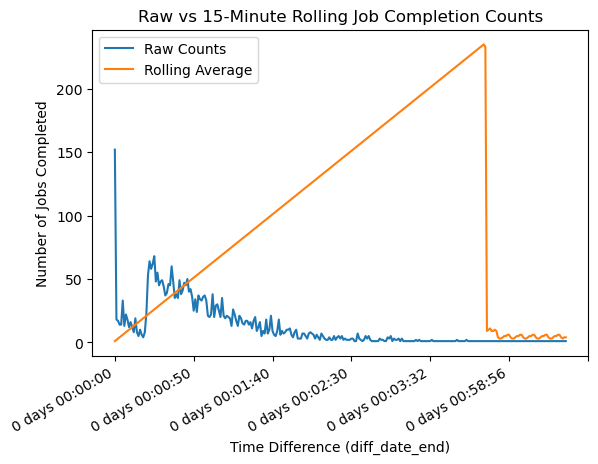

In [43]:
# Compute a 15-minute rolling count of completed jobs
num_jobs['rolling_15min'] = num_jobs.rolling(window ='15min', on='diff_date_end')['num_jobs_completed'].count()

# Visualization of the 5-min rolling count of completed jobs
ax = num_jobs.plot(x='diff_date_end', y='num_jobs_completed', label= 'Raw Counts')
num_jobs.plot(x='diff_date_end', y='rolling_15min', label= 'Rolling Average', ax=ax);
ax.set_xlabel("Time Difference (diff_date_end)")
ax.set_ylabel("Number of Jobs Completed")
ax.set_title("Raw vs 15-Minute Rolling Job Completion Counts")
ax.legend();

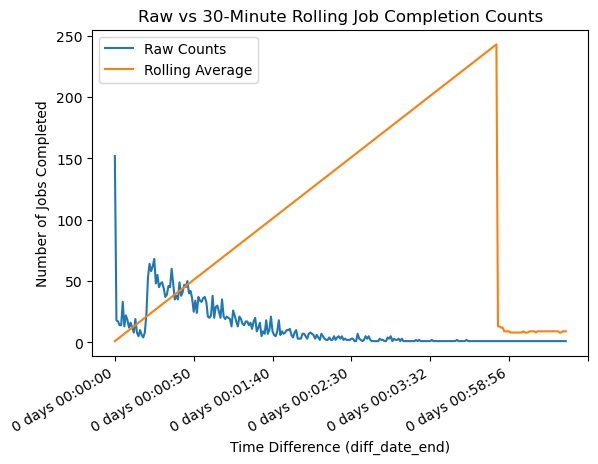

In [44]:
# Compute a 30-minute rolling count of completed jobs
num_jobs['rolling_30min'] = num_jobs.rolling(window ='30min', on='diff_date_end')['num_jobs_completed'].count()

# Visualization of the 5-min rolling count of completed jobs
ax = num_jobs.plot(x='diff_date_end', y='num_jobs_completed', label= 'Raw Counts')
num_jobs.plot(x='diff_date_end', y='rolling_30min', label= 'Rolling Average', ax=ax)
ax.set_xlabel("Time Difference (diff_date_end)")
ax.set_ylabel("Number of Jobs Completed")
ax.set_title("Raw vs 30-Minute Rolling Job Completion Counts")
ax.legend();

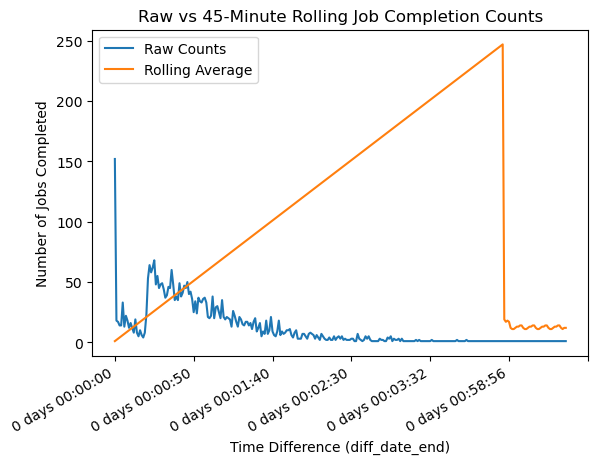

In [45]:
# Compute a 45-minute rolling count of completed jobs
num_jobs['rolling_45min'] = num_jobs.rolling(window ='45min', on='diff_date_end')['num_jobs_completed'].count()

# Visualization of the 5-min rolling count of completed jobs
ax = num_jobs.plot(x='diff_date_end', y='num_jobs_completed', label= 'Raw Counts')
num_jobs.plot(x='diff_date_end', y='rolling_45min', label= 'Rolling Average', ax=ax)
ax.set_xlabel("Time Difference (diff_date_end)")
ax.set_ylabel("Number of Jobs Completed")
ax.set_title("Raw vs 45-Minute Rolling Job Completion Counts")
ax.legend();

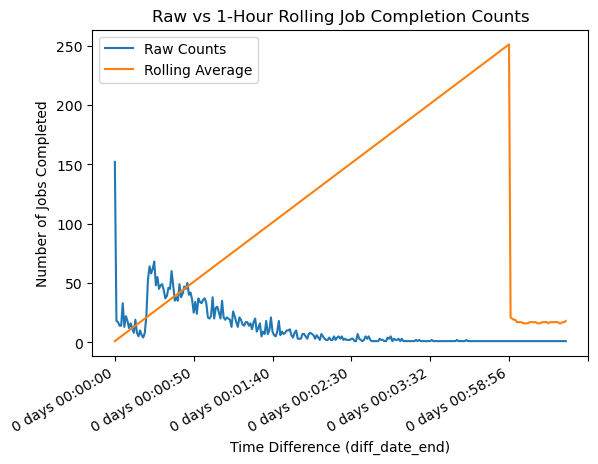

In [46]:
# Compute a 1hr rolling count of completed jobs
num_jobs['rolling_1h'] = num_jobs.rolling(window ='1h', on='diff_date_end')['num_jobs_completed'].count()

# Visualization of the 5-min rolling count of completed jobs
ax = num_jobs.plot(x='diff_date_end', y='num_jobs_completed', label= 'Raw Counts')
num_jobs.plot(x='diff_date_end', y='rolling_1h', label= 'Rolling Average', ax=ax)
ax.set_xlabel("Time Difference (diff_date_end)")
ax.set_ylabel("Number of Jobs Completed")
ax.set_title("Raw vs 1-Hour Rolling Job Completion Counts")
ax.legend();

* Most unresponsive events fall with in 1-Hour but this is not enough evidence.

**Phase 3: Analyze and Visualize**  
Objectives:  
* Explore the relationship between job completions and unresponsiveness.  
* Create visualizations and basic summary statistics.  

* Explore the relationship between job completions and unresponsiveness.

In [47]:
#Round RND to hour
merge_unresp_jobs['hour'] = merge_unresp_jobs['END'].dt.floor('h')
#Count completed jobs per hour
completed_per_hour = merge_unresp_jobs.groupby('hour')['JOBID'].size().rename('completed_jobs_hour')

In [49]:
#count unresponsive jobs under 1 hour
unresponsive_per_hour = merge_unresp_jobs[merge_unresp_jobs['diff_date_end'] <= '0 days 01:00:00'].groupby('hour')['JOBID'].size().astype(int).rename('unresponsive_jobs_hour')
#combine into single dataframe
combine_1hr = pd.concat([completed_per_hour,unresponsive_per_hour], axis=1).fillna(0)



In [50]:
combine_1hr.nlargest(2, 'completed_jobs_hour')

,completed_jobs_hour,unresponsive_jobs_hour
hour,,
2021-05-18 06:00:00,52,16
2020-12-04 15:00:00,26,26


In [51]:
#count unresponsive jobs 30min to 1hr
unresp_between_1h_30m = merge_unresp_jobs[(merge_unresp_jobs['diff_date_end'] > '0 days 00:30:00') & (merge_unresp_jobs['diff_date_end'] <= '0 days 01:00:00')]

unresponsive_1h_30m = unresp_between_1h_30m.groupby('hour')['JOBID'].count().astype(int).rename('unresponsive_jobs_1hr_30min')
#combine into single dataframe
combine_1hr_30min = pd.concat([completed_per_hour,unresponsive_1h_30m], axis=1).fillna(0)
combine_1hr_30min['unresponsive_jobs_1hr_30min']= combine_1hr_30min['unresponsive_jobs_1hr_30min'].astype(int)

In [52]:
combine_1hr_30min['unresponsive_jobs_1hr_30min'].sum()

np.int64(8)

In [53]:
#count unresponsive jobs  0 to 30min 
unresponsive_0_30m = merge_unresp_jobs[merge_unresp_jobs['diff_date_end'] <= '0 days 00:30:00'].groupby('hour')['JOBID'].count().astype(int).rename('unresponsive_0_30min')
combine_0_30m = pd.concat([completed_per_hour,unresponsive_per_hour], axis=1).fillna(0)


In [54]:
combine_0_30m['unresponsive_jobs_hour'].sum()

np.int64(3260)

In [55]:
#count unresponsive jobs  under 15min
unresponsive_15m = merge_unresp_jobs[merge_unresp_jobs['diff_date_end'] <= '0 days 00:15:00'].groupby('hour')['JOBID'].count().astype(int).rename('unresponsive_15min')
combine_15m = pd.concat([completed_per_hour,unresponsive_15m], axis=1).fillna(0)


In [56]:
combine_15m['unresponsive_15min'].sum()

np.int64(3244)

In [59]:
#count unresponsive jobs  under 10min
unresponsive_10m = merge_unresp_jobs[merge_unresp_jobs['diff_date_end'] <= '0 days 00:10:00'].groupby('hour')['JOBID'].count().astype(int).rename('unresponsive_10min')
combine_10m = pd.concat([completed_per_hour,unresponsive_10m], axis=1).fillna(0)


In [60]:
combine_10m['unresponsive_10min'].sum()

np.float64(3237.0)

In [62]:
#count unresponsive jobs  under 2min
unresponsive_2m = merge_unresp_jobs[merge_unresp_jobs['diff_date_end'] <= '0 days 00:02:00'].groupby('hour')['JOBID'].count().astype(int).rename('unresponsive_2min')
combine_2m = pd.concat([completed_per_hour,unresponsive_2m], axis=1).fillna(0)


In [63]:
combine_2m['unresponsive_2min'].sum()

np.float64(2995.0)